# Modelling

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    make_scorer,
    roc_auc_score
)
from xgboost import XGBClassifier

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.ml_tools import train_model, model_evaluation

In [38]:
np.random.seed(42)

## Import data

In [39]:
data = pd.read_csv('../data/cleaned_engineered_data.csv')

In [40]:
X = data.drop(columns=['Churn'])
y = data['Churn']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

## Baseline

This analysis implements a contract-based heuristic baseline for churn prediction, leveraging the relationship between customer contract duration and churn behavior. The approach uses data-driven thresholds rather than simple rule-based predictions

In [41]:
import plotly.express as px
contract_churn_rates = {}
for contract_type in ['Month-to-month', 'One year', 'Two year']:
    if f'Contract_{contract_type}' in X_train.columns:
        mask = X_train[f'Contract_{contract_type}'] == 1
        churn_rate = y_train[mask].mean()
        contract_churn_rates[contract_type] = churn_rate
        print(f"{contract_type} churn rate: {churn_rate:.3f}")

# Use the churn rates to set thresholds
# Predict churn if customer has contract type with churn rate > threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = np.zeros(len(X_test))
    
    for contract_type, churn_rate in contract_churn_rates.items():
        if churn_rate > t and f'Contract_{contract_type}' in X_test.columns:
            mask = X_test[f'Contract_{contract_type}'] == 1
            preds[mask] = 1
    
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

fig = px.line(
    x=thresholds,
    y=f1_scores,
    labels={"x": "Churn Rate Threshold", "y": "F1 Score"},
    title="Contract-based Heuristic Baseline: Threshold vs F1 Score"
)
fig.show()

print(f"Best Contract F1 Score: {max(f1_scores):.3f}")

Month-to-month churn rate: 0.431
One year churn rate: 0.108
Two year churn rate: 0.025


Best Contract F1 Score: 0.574


Baseline Achievement:
- Best F1 Score: 0.574
- Optimal Threshold: 0.424

Implications:
- This suggests Contract type has significant predictive power for churn
- The optimal threshold lower than standard (0.5) indicates that churn class is less frequent than non-churn

## Model training

In [42]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [43]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
results = {}

for name, model in models.items():
    
    results[name] = train_model(name, model, X_train, y_train)

# Select best model based on ROC AUC (you can change this criterion)
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_roc_auc'])
best_model = results[best_model_name]['model']
best_scores = results[best_model_name]

print(f"Selected: {best_model_name}")
print(f'ROC AUC (avg 5-fold): {best_scores["cv_roc_auc"]:.4f}')
print(f'F1 Score (avg 5-fold): {best_scores["cv_f1"]:.4f}')

Logistic Regression:
  ROC AUC: 0.8522 ± 0.0108
  F1:      0.5900 ± 0.0229
  Precision: 0.6643
  Recall:    0.5326

Random Forest:
  ROC AUC: 0.8173 ± 0.0158
  F1:      0.5534 ± 0.0294
  Precision: 0.6260
  Recall:    0.4969



/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost:
  ROC AUC: 0.8221 ± 0.0096
  F1:      0.5636 ± 0.0256
  Precision: 0.6187
  Recall:    0.5201

Selected: Logistic Regression
ROC AUC (avg 5-fold): 0.8522
F1 Score (avg 5-fold): 0.5900


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Observations
- Logistic Regression model yields the best performance initially, achieving ROC AUC score of 0.8488, and F1 score of 0.5922

Insights
- The F1 score is only slightly better than  heuristic baseline of 0.574, which suggests there's room for improvement in precision/recall balance
- The gap between your ROC AUC (0.8488) and F1 score (0.5922) indicates that:
    - The model is good at ranking predictions (ROC AUC) But there might be issues with the **classification threshold** or **class imbalance**

### Logistic regression

#### Hyperparameter tuning

In [49]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']
}

scoring = {'f1': make_scorer(f1_score), 'roc_auc': 'roc_auc'}

# Perform grid search
grid_search = GridSearchCV(results['Logistic Regression']['model'], param_grid, cv=cv_strategy, scoring=scoring, refit='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)

lr_model = grid_search.best_estimator_

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score from CV: 0.6394840044435212


Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score from CV: 0.6379154906361695


In [50]:
# Optional: Validate threshold on X_val
y_prob_val = lr_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (y_prob_val >= thresh).astype(int)) for thresh in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold on Val: {optimal_threshold:.2f}")

Optimal Threshold on Val: 0.60


#### Evaluate model

In [51]:
res = model_evaluation(lr_model, X_train, y_train, X_test, y_test)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6438
Test F1:        0.6224
F1 Difference:  0.0215 ✅

Training ROC:   0.8533
Test ROC:       0.8445
ROC Difference: 0.0087

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6224
Improvement:        +0.0484 (+8.4%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  756
False Positives (Wrong Churn):      279
False Negatives (Missed Churn):     79
True Positives (Correct Churn):     295

Churn Capture Rate: 78.9% (How many churners did we catch?)
Precision Rate:     51.4% (How accurate are o

In [52]:
lr_performance = pd.DataFrame(['Linear Regression', res['train_f1'], res['train_roc_auc'], res['test_f1'], res['test_roc_auc']]).transpose()
lr_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
lr_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Linear Regression,0.643816,0.853264,0.622363,0.844517


#### Threshold optimization

In [ ]:
# Step 2: Predict probabilities
y_prob_val = lr_model.predict_proba(X_train)[:, 1]  # Probability of churn

# Step 3: Optimize threshold
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_train, (y_prob_val >= thresh).astype(int)) for thresh in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Validation F1: {max(f1_scores):.4f}")

# Step 4: Apply to test set
y_prob_test = lr_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= optimal_threshold).astype(int)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test F1 with Optimal Threshold: {test_f1:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Optimal Threshold: 0.52
Max Validation F1: 0.6444
Test F1 with Optimal Threshold: 0.6230
Test ROC AUC: 0.8453


In [ ]:
#Get probabilities from your best model
y_prob = lr_model.predict_proba(X_val)[:, 1]

# Find optimal threshold for F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1]  

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

print(f"Current F1 with default threshold (0.5): {f1_score(y_test, lr_model.predict(X_test)):.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Max possible F1 with threshold tuning: {max_f1:.4f}")
print(f"Potential F1 improvement: +{max_f1 - 0.5846:.4f}")

y_pred_final = (y_prob >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

Current F1 with default threshold (0.5): 0.6234
Optimal threshold: 0.5522
Max possible F1 with threshold tuning: 0.6322
Potential F1 improvement: +0.0476
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

[[814 221]
 [ 99 275]]


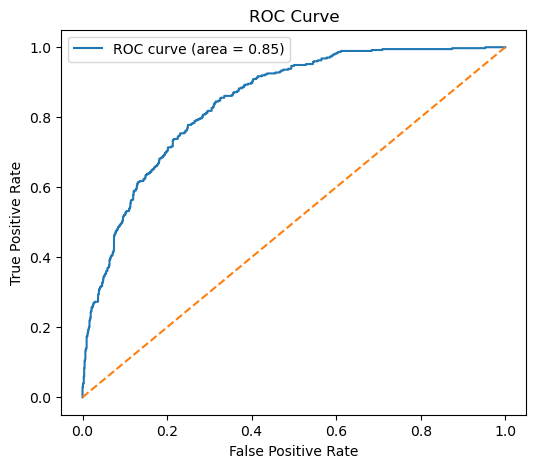

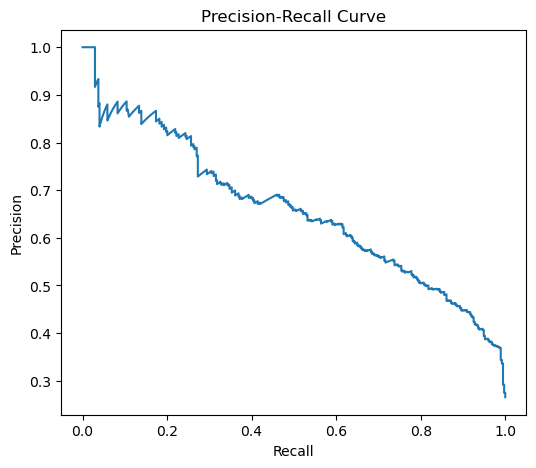

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.show()

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.show()


In [48]:
feature_importance = pd.Series(lr_model.coef_[0], index=X_test.columns).sort_values(ascending=False)
print(feature_importance.head(10))

ChargePerMonthRatio            0.199773
Contract_Month-to-month        0.098293
M2M_ElectronicCheck            0.090700
InternetService_Fiber optic    0.081562
Fiber_NoTechSupport            0.080313
PaperlessBilling               0.062549
tenure_group_0–6               0.048366
new_customer                   0.048366
AddOnGroup_Low                 0.046135
FiberOptic_StreamingTV         0.043556
dtype: float64


Key Takeaways
- ChargePerMonthRatio is the most influential predictor, suggesting that how much a customer pays relative to their average or base charge is a strong churn indicator.
- Month-to-month contracts are highly associated with churn, aligning with common behavior where customers without long-term commitment are more likely to leave.
- Fiber optic internet and Electronic Check payment are linked with higher churn risks — these services or methods may be pain points
- Paperless billing also shows a positive correlation with churn, potentially reflecting lower engagement or tech-savvy customers who churn more.
- Features involving fiber users with no tech support or streaming services contribute to churn, suggesting dissatisfaction when support or services are lacking.
- Senior citizens on contracts and streaming habits are meaningful, possibly showing age-based behavior patterns.
- Multiple lines has lower importance but still contributes slightly.

Implications: Focus churn reduction efforts on:
- Users with high relative monthly charges
- Those on month-to-month plans
- Users with fiber optic service but no tech support or added services
- Customers using electronic check payment
- Users with paperless billing, as they may be less engaged

## Random Forest

In [ ]:
rf_model = results['Random Forest']['model']

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv_strategy,
    scoring=scoring,
    refit='f1',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score from CV:", random_search.best_score_)

rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best F1 Score from CV: 0.6385691478653888


In [19]:
rf_res = model_evaluation(rf_model, X_train, y_train, X_test, y_test)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6992
Test F1:        0.6291
F1 Difference:  0.0701 ⚠️ Possible overfitting

Training ROC:   0.9056
Test ROC:       0.8415
ROC Difference: 0.0641

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6291
Improvement:        +0.0551 (+9.6%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.90      0.75      0.82      1035
       Churn       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  777
False Positives (Wrong Churn):      258
False Negatives (Missed Churn):     84
True Positives (Correct Churn):     290

Churn Capture Rate: 77.5% (How many churners did we catch?)
Precision Rate:     52.

In [20]:
rf_performance = pd.DataFrame(['Random Forest', rf_res['train_f1'], rf_res['train_roc_auc'], rf_res['test_f1'], rf_res['test_roc_auc']]).transpose()
rf_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
rf_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Random Forest,0.699161,0.905583,0.629067,0.841505


🔧 Best Threshold: 0.4989
🎯 Best F1 Score: 0.6306


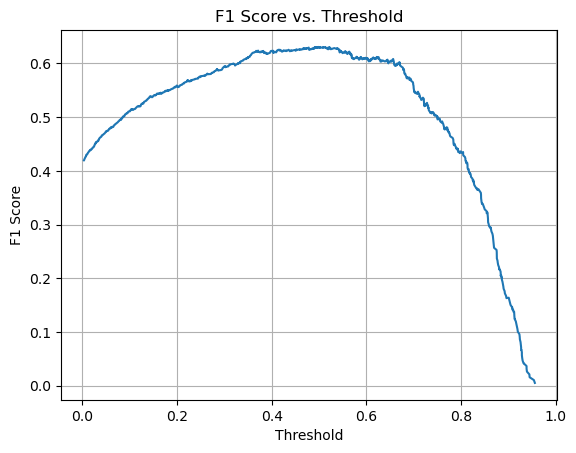


Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409

Confusion Matrix:
 [[777 258]
 [ 83 291]]


In [21]:
# Get predicted probabilities for the positive class
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🔧 Best Threshold: {best_threshold:.4f}")
print(f"🎯 Best F1 Score: {best_f1:.4f}")

# Optional: Visualize
plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.show()

# Re-predict using the best threshold
y_pred_opt = (y_probs >= best_threshold).astype(int)

# Classification report
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))

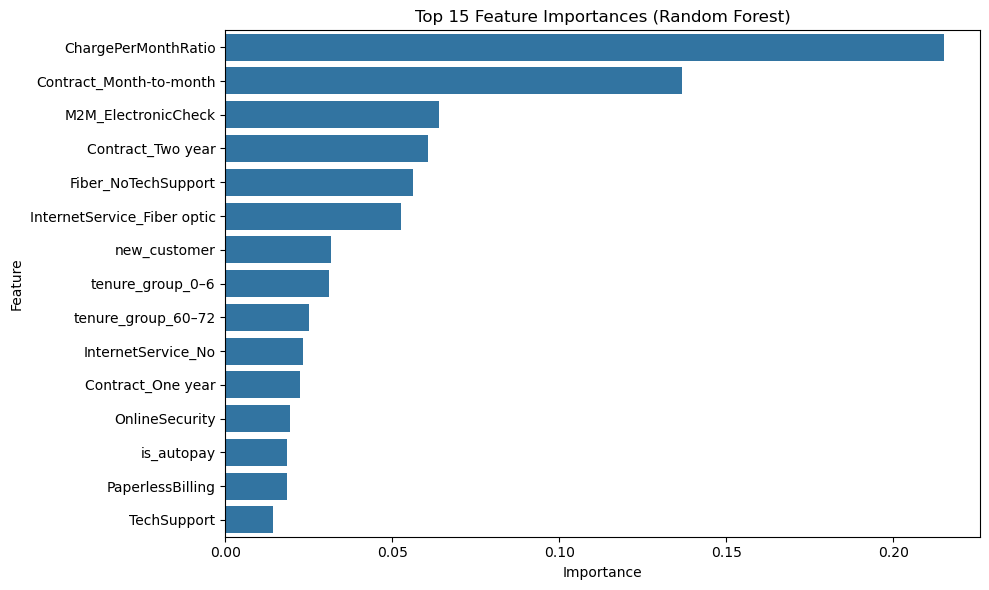

In [22]:
import seaborn as sns
# Get feature importances from RF model
importances = rf_model.feature_importances_
feat_names = X_train.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 1.5, 2.0],
    'reg_alpha' : [0, 0.1, 0.5]
}

xgb_random = RandomizedSearchCV(
    estimator=results['XGBoost']['model'],
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("Best Parameters:", xgb_random.best_params_)
print("Best F1 Score from CV:", xgb_random.best_score_)

xgb = xgb_random.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:49:42] WARNING: /Users/runner/work/xgboost/

Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 1.0}
Best F1 Score from CV: 0.5885382114590275


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[14:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [24]:
xgb_res = model_evaluation(xgb, X_train, y_train, X_test, y_test)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6066
Test F1:        0.5817
F1 Difference:  0.0249 ✅

Training ROC:   0.8609
Test ROC:       0.8463
ROC Difference: 0.0146

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.5817
Improvement:        +0.0077 (+1.3%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  936
False Positives (Wrong Churn):      99
False Negatives (Missed Churn):     180
True Positives (Correct Churn):     194

Churn Capture Rate: 51.9% (How many churners did we catch?)
Precision Rate:     66.2% (How accurate are o

In [25]:
xgb_performance = pd.DataFrame(['XGBoost', xgb_res['train_f1'], xgb_res['train_roc_auc'], xgb_res['test_f1'], xgb_res['test_roc_auc']]).transpose()
xgb_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
xgb_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,XGBoost,0.606614,0.86089,0.581709,0.84631


In [26]:
models_performance = pd.concat([lr_performance, rf_performance, xgb_performance])

In [27]:
models_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Linear Regression,0.640236,0.851219,0.623404,0.845328
0,Random Forest,0.699161,0.905583,0.629067,0.841505
0,XGBoost,0.606614,0.86089,0.581709,0.84631


/var/folders/s7/04p7rk5x2vq16cj0qsb9p82r0000gn/T/ipykernel_5785/1129046084.py:4: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



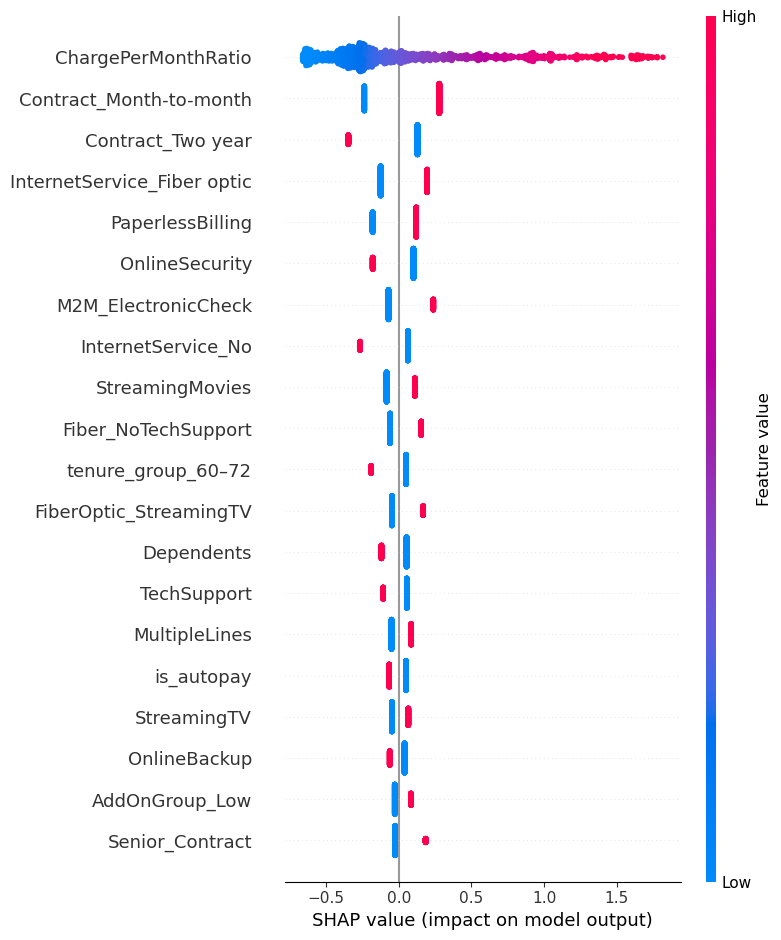

In [28]:
import shap
explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)